In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import datetime
from matplotlib.ticker import ScalarFormatter
from pylab import rcParams

In [2]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1277942400&to=1640995200"
data = requests.get(url).json()
df = pd.DataFrame.from_dict(data, orient='index').transpose()

# Problema: Verificar o index do dado errado para possível correção mais para a frente

Existe um dados por volta de 2017 na coluna de "Market Cap" que está alterado com o dado do dia seguinte por nao existir qualquer dado para aquele dia em relação ao "market cap".
Para contornar este problema decidimos encontrar o index do dia em que se encontra o erro nos dados e substituir por 0.

In [3]:
#Verificar o index do dado errado para possível correção mais para a frente
def Worng_value_check(prices, marketcaps):
    for i in range(len(prices)):
        price = prices[i]
        marketcap = marketcaps[i]
        if price[0] != marketcap[0]:
            return(i)
            break
            
print("O dado com problemas está situado no index:", Worng_value_check(df["prices"], df["market_caps"]))

O dado com problemas está situado no index: 1433


Como a data "1491091200000" se encontra no dia 2 de Abril de 2017, não causará nenhum problema nos cálculos nem gráficos apresentados neste trabalho. Com isto, ao substituir por 0 no dataframe "limpo" e colocar os restantes dados nas posições corretas, foi possível usar estes dados para o nosso objetivo sem problema algum.

In [4]:
def limpeza_dados_preco(prices, marketcaps, volumes):
    
    # Novas variáveis globais para limpeza dos dados e cração de um novo dataframe
    # A conversão para uma variável "global" serve para essa variável se tornar "pública" e poder ser usada fora da função
    global cleanprices, cleanmarketcap, cleanvolume, cleandate
    cleanprices = []
    cleanmarketcap = []
    cleanvolume = []
    cleandate = []
    
    #Loop para limpeza dos dados
    for i in range(len(prices)):
        #if statement para corrigir o erro do dado incorreto, substituindo o dado incorreto por 0 e usando os dados anteriores para as datas seguintes
        if i < Worng_value_check(df["prices"], df["market_caps"]):
            marketcap = marketcaps[i]
        elif i > Worng_value_check(df["prices"], df["market_caps"]):
            marketcap = marketcaps[i-1]
        elif i == Worng_value_check(df["prices"], df["market_caps"]):
            marketcap = [0, 0]
        price = prices[i]
        volume = volumes[i]
        epoch_time = price [0]
        
        #Adicionar integers de preço, volume e marketcap sem integers de tempo epoch a mais
        cleanmarketcap.append(marketcap[1])
        cleanvolume.append(volume[1])
        cleanprices.append(price[1])
        cleandate.append(epoch_time/1000)

#Criação de dicionairio "btcusd" para o data frame usando os dados limpos, mais organizados e corretos
limpeza_dados_preco(df["prices"], df["market_caps"], df["total_volumes"])
btcusd = {"Data":cleandate, 
          "BTCUSD":cleanprices,
          "MarketCap":cleanmarketcap, 
          "Volume":cleanvolume}

#Criação da nova dataframe.
df_btc_prices = pd.DataFrame(data=btcusd)

#Começar index com 1 indicando o dia
df_btc_prices.index += 1

#Converter tempo epoch em tempo ISO 8601 para ser percetível a qualquer humano ler a data
df_btc_prices["Data"] = pd.to_datetime(df_btc_prices["Data"], unit="s")

#Dado em falta: nao existe dado de Marketcap para o dia 02 de Abril de 2017, ficando assim em 0, no dia/index 1187 (df_btc_prices.loc[1187])
df_btc_prices

,Data,BTCUSD,MarketCap,Volume
1,2013-04-28,135.300000,1.500518e+09,0.000000e+00
2,2013-04-29,141.960000,1.575032e+09,0.000000e+00
3,2013-04-30,135.300000,1.501657e+09,0.000000e+00
4,2013-05-01,117.000000,1.298952e+09,0.000000e+00
5,2013-05-02,103.430000,1.148668e+09,0.000000e+00
...,...,...,...,...
2947,2021-05-24,34977.527802,6.545590e+11,8.435803e+10
2948,2021-05-25,38642.442297,7.231431e+11,7.116320e+10
2949,2021-05-26,38210.805218,7.152487e+11,4.872479e+10
2950,2021-05-27,39406.934244,7.376687e+11,4.702639e+10


In [5]:
df_btc_prices.to_csv("bitcoin_price_marketcap_volume_20130428_20210528.csv", index=False)

# Gráfico de preço hitórico entre 2014 e 2021

Criação de gráfico de preço e volume, um em cima do outro usando "subplot array" para separar os dois gráficos. Para melhor interpretação dos gráficos foi escolhido um simples gráfico de linhas para a representação do preço e um gráfico de barras para a representação do volume de compra e venda da moeda virtual denominada por "bitcoin".

<IPython.core.display.Javascript object>


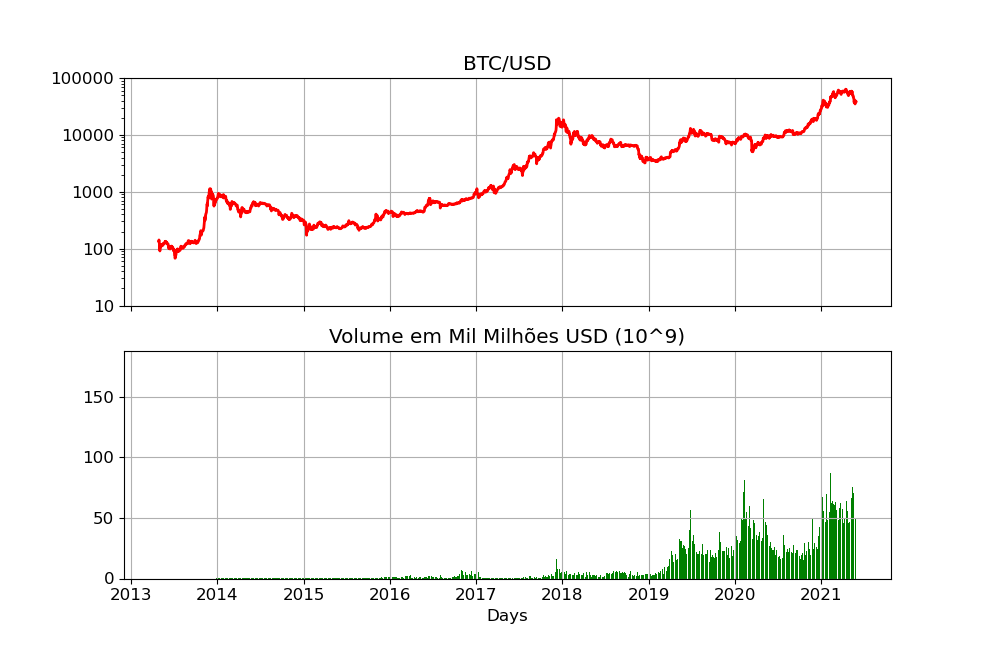

In [25]:
%matplotlib notebook
fig, axarr = plt.subplots(2, sharex=True)

axarr[0].set_title("BTC/USD")
axarr[0].plot(df_btc_prices["Data"], 
              df_btc_prices["BTCUSD"], 
              label = "BTC/USD", 
              linewidth = "2",
              color = "r")

axarr[1].set_title("Volume em Mil Milhões USD (10^9)")
axarr[1].bar(df_btc_prices["Data"], 
             df_btc_prices["Volume"]/1000000000, 
             color = "g",
             label = "MarketCap")

# rcParams neste caso serve para controlar o tamanho da imagem renderizada e do texto
rcParams['figure.figsize'] = 9.9, 6.5
rcParams['font.size'] = 12
rcParams['figure.dpi'] = 100

# ticklabel_format foi necessário para apresentar o eixo y de volume em notação normal, pois em autmoático apresentava 
# sempre em notação científica 
plt.xlabel("Days")

# set_yscale("log") para usar escala logarítmica na atuação do preço
axarr[0].set_yscale("log")
axarr[0].set_yticks([10, 100, 1000, 10000, 100000])

# as três linhas de código abaixo foram necessárias para não usar notação cientifica nas labels do gráfico de preço
axarr[0].get_yaxis().set_major_formatter(ScalarFormatter())
axarr[0].ticklabel_format(axis="y", style='plain')
plt.ticklabel_format(axis="y", style='plain')

axarr[0].grid()
plt.grid()

# Calculo de ROI anual

De modo a fazer o cálculo de "Return on Investment" tivemos que obter, da base de dados inicial, os dados necessários para os cáclculos de ROI de 30, 60, 90 dias e anual. Para isso algumas listas de controlo foram criadas como, "iniciais_anuais", "preços_anuais" e "iniciais".  

A forma de cálculo do ROI é simples, após obter os dados corretos, usando a seguinte fórmula: (Receita - Custo)/Custo*100. O ROI calculado nao tem em conta taxas que possam ser aplicadas pela Casa de Câmbio usada

In [7]:
# Lista de controlo para obter os preços do dia 1 de cada ano
iniciais_anuais = ['2021-01-01 00:00:00', 
                   '2020-01-01 00:00:00', 
                   '2019-01-01 00:00:00', 
                   '2018-01-01 00:00:00',
                   '2017-01-01 00:00:00', 
                   '2016-01-01 00:00:00', 
                   '2015-01-01 00:00:00', 
                   '2014-01-01 00:00:00']

# Lista para uso no gráfico como eixo horizontal
anos = [2014, 2015, 2016, 2017, 2018, 2019, 2020]

# Lista vazia para obter os preços do dia 1 de cada ano
preços_anuais = []

# Loop for para obter os preços do dia 1 de cada ano
for i in range(len(df_btc_prices)):
    if str(df_btc_prices.loc[i+1]["Data"]) in iniciais_anuais:
        preços_anuais.append(df_btc_prices.loc[i+1]["BTCUSD"])

# Cálculo de ROI em cada ano, utilizando o preço inicial do ano em que comprou e o preço do ano seguinte
roi_anual = []
for i in range(len(preços_anuais)):
    # If statement para parar o loop e nao tentar calcular o ROI do ano 2021, daría erro por nao haver ainda preço 
    # do dia 01-01-2022
    if i+1 > len(preços_anuais)-1:
        break
    roi = (preços_anuais[i+1]-preços_anuais[i])/preços_anuais[i]*100
    roi_anual.append(roi)
    
# Eliminar peço 2021 para colocar no dataframe
preços_anuais.pop()

# Criação de Dataframe
ROI_anual_dict = {"Ano":anos, "ROI":roi_anual, "Preço Inicial":preços_anuais}

# Criação dataframe limpa.
ROI_anual = pd.DataFrame(data=ROI_anual_dict)

# Começar index com 1 indicando o dia
ROI_anual.index += 1

# Média Anual para criação de linha horizontal com o ROI médio durante a amostra dos 7 anos
média_roi_anual = ROI_anual["ROI"].mean()
ROI_anual

,Ano,ROI,Preço Inicial
1,2014,-59.101779,767.740000
2,2015,38.356073,313.992000
3,2016,129.739404,434.427000
4,2017,1312.114306,998.050000
5,2018,-73.799953,14093.606831
6,2019,94.856937,3692.531566
7,2020,303.360634,7195.153895


In [8]:
ROI_anual.to_csv("bitcoin_roi_anual_2014-2020.csv", index=False)

# Representação gráfica de ROI Anual

<IPython.core.display.Javascript object>


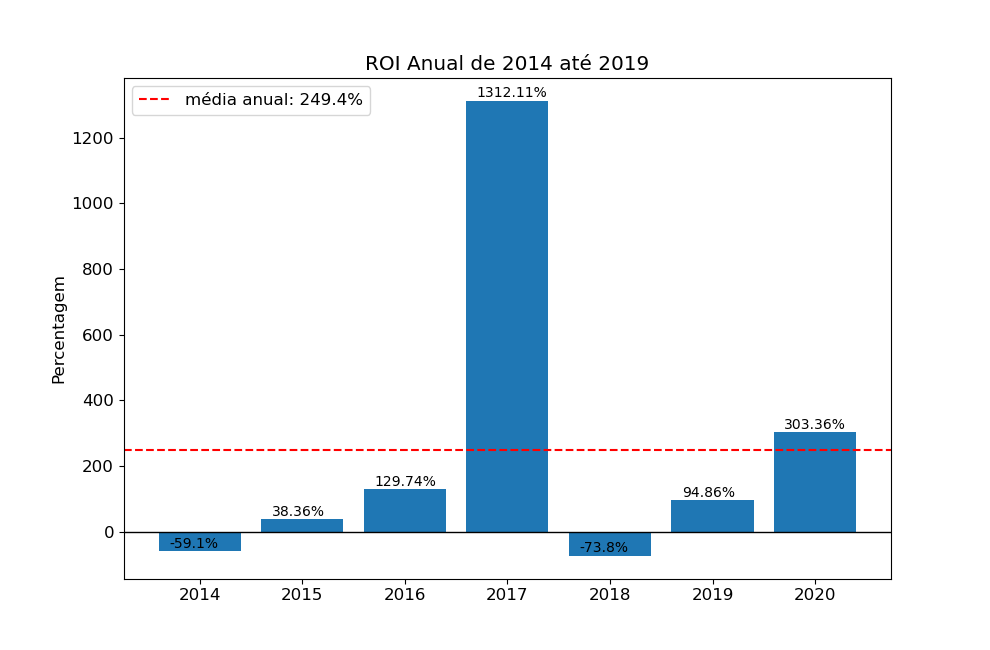

In [21]:
%matplotlib notebook
fig, ax = plt.subplots()

ax.bar(ROI_anual["Ano"], ROI_anual["ROI"])

# Criação da linha horizontal de média
plt.axhline(y = média_roi_anual, color = 'r', linestyle = 'dashed', label = "média anual: "+str(round(média_roi_anual, 1))+"%")  

plt.legend(loc="upper left")
plt.axhline(y = 0, color = 'black', linewidth=1) 
plt.ylabel('Percentagem')

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(ROI_anual["ROI"]):
    plt.text(ROI_anual["Ano"][i+1]-0.3, v+10, str(round(ROI_anual["ROI"][i+1],2))+'%', fontsize=10)

plt.title('ROI Anual de 2014 até 2019')
plt.show()

# Cálculo de ROI de 30, 60 e 90 Dias.

In [10]:
# Lista de controlo para obter os preços do dia 1 de cada mês, dividido por "nested lists" por ano
iniciais = [
    ['2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00','2020-05-01 00:00:00','2020-06-01 00:00:00','2020-07-01 00:00:00','2020-08-01 00:00:00','2020-09-01 00:00:00','2020-10-01 00:00:00','2020-11-01 00:00:00','2020-12-01 00:00:00'], 
    ['2019-01-01 00:00:00','2019-02-01 00:00:00','2019-03-01 00:00:00','2019-04-01 00:00:00','2019-05-01 00:00:00','2019-06-01 00:00:00','2019-07-01 00:00:00','2019-08-01 00:00:00','2019-09-01 00:00:00','2019-10-01 00:00:00','2019-11-01 00:00:00','2019-12-01 00:00:00'],
    ['2018-01-01 00:00:00','2018-02-01 00:00:00','2018-03-01 00:00:00','2018-04-01 00:00:00','2018-05-01 00:00:00','2018-06-01 00:00:00','2018-07-01 00:00:00','2018-08-01 00:00:00','2018-09-01 00:00:00','2018-10-01 00:00:00','2018-11-01 00:00:00','2018-12-01 00:00:00'],
    ['2017-01-01 00:00:00','2017-02-01 00:00:00','2017-03-01 00:00:00','2017-04-01 00:00:00','2017-05-01 00:00:00','2017-06-01 00:00:00','2017-07-01 00:00:00','2017-08-01 00:00:00','2017-09-01 00:00:00','2017-10-01 00:00:00','2017-11-01 00:00:00','2017-12-01 00:00:00'],
    ['2016-01-01 00:00:00','2016-02-01 00:00:00','2016-03-01 00:00:00','2016-04-01 00:00:00','2016-05-01 00:00:00','2016-06-01 00:00:00','2016-07-01 00:00:00','2016-08-01 00:00:00','2016-09-01 00:00:00','2016-10-01 00:00:00','2016-11-01 00:00:00','2016-12-01 00:00:00'],
    ['2015-01-01 00:00:00','2015-02-01 00:00:00','2015-03-01 00:00:00','2015-04-01 00:00:00','2015-05-01 00:00:00','2015-06-01 00:00:00','2015-07-01 00:00:00','2015-08-01 00:00:00','2015-09-01 00:00:00','2015-10-01 00:00:00','2015-11-01 00:00:00','2015-12-01 00:00:00'],
    ['2014-01-01 00:00:00','2014-02-01 00:00:00','2014-03-01 00:00:00','2014-04-01 00:00:00','2014-05-01 00:00:00','2014-06-01 00:00:00','2014-07-01 00:00:00','2014-08-01 00:00:00','2014-09-01 00:00:00','2014-10-01 00:00:00','2014-11-01 00:00:00','2014-12-01 00:00:00']
]

# Lista de meses para uso gráfico
meses = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]

# Função para o cálculo de ROI, com quantidade de dias variável, mensal.
def ROIcalculator(dias, df_btc_prices, ano):
    
    # Novas variáveis globais para limpeza dos dados e cração de um novo dataframe
    # A conversão para uma variável "global" serve para essa variável se tornar "pública" e poder ser usada fora da função
    global roixdias
    
    # Lista de resultador final para o ROI
    roixdias = []
    for i in range(1, len(df_btc_prices)):
        
        # If statements para seleção da lista controlo de acordo com o ano escolhido
        if ano == 2020:
            inicial_de_cada_mes = iniciais[0]
        if ano == 2019:
            inicial_de_cada_mes = iniciais[1]
        if ano == 2018:
            inicial_de_cada_mes = iniciais[2]
        if ano == 2017:
            inicial_de_cada_mes = iniciais[3]
        if ano == 2016:
            inicial_de_cada_mes = iniciais[4]
        if ano == 2015:
            inicial_de_cada_mes = iniciais[5]
        if ano == 2014:
            inicial_de_cada_mes = iniciais[6]
            
        # If statement para uso da lista controlo
        if str(df_btc_prices.loc[i]["Data"]) in inicial_de_cada_mes:
            
            # Fórmula para o cálculo de ROI
            roi = (df_btc_prices.loc[i+dias]["BTCUSD"]-df_btc_prices.loc[i]["BTCUSD"])/df_btc_prices.loc[i]["BTCUSD"]*100
            roixdias.append(roi)

In [11]:
# Criação de Dataframes para ROI 30, 60 e 90 dias
roi90mensal = pd.DataFrame(data=meses, columns=["Meses"])
roi60mensal = pd.DataFrame(data=meses, columns=["Meses"])
roi30mensal = pd.DataFrame(data=meses, columns=["Meses"])
roi90mensal.index += 1
roi60mensal.index += 1
roi30mensal.index += 1

# Loop para criação de colunas nos dataframes de acordo com o ano
for i in range(2014, 2021):
    # Loop para criação de colunas nos dataframes de acordo com o numero de dias de ROI
    for dias in [30, 60, 90]:
        # Uso da função anterior para o cáculo de ROI
        ROIcalculator(dias, df_btc_prices, i)
        # If statements para controlar em que dataframes são criadas as colunas (roi30mensal, roi60mensal ou roi90mensal)
        if dias == 30:
            roi30mensal["ROI "+str(dias)+" Dias "+str(i)] = roixdias
        elif dias == 60:
            roi60mensal["ROI "+str(dias)+" Dias "+str(i)] = roixdias
        elif dias == 90:
            roi90mensal["ROI "+str(dias)+" Dias "+str(i)] = roixdias

# ROI 90 dias médio durante 2020, 2019, 2018, 2017, 2016, 2015 e 2014
roi90mensal["ROI 90 Dias Médio"] = (roi90mensal["ROI 90 Dias 2020"] + 
                                    roi90mensal["ROI 90 Dias 2019"] + 
                                    roi90mensal["ROI 90 Dias 2018"] + 
                                    roi90mensal["ROI 90 Dias 2017"] + 
                                    roi90mensal["ROI 90 Dias 2016"] + 
                                    roi90mensal["ROI 90 Dias 2015"] + 
                                    roi90mensal["ROI 90 Dias 2014"] )/7

# ROI 60 dias médio durante 2020, 2019, 2018, 2017, 2016, 2015 e 2014
roi60mensal["ROI 60 Dias Médio"] = (roi60mensal["ROI 60 Dias 2020"] + 
                                    roi60mensal["ROI 60 Dias 2019"] + 
                                    roi60mensal["ROI 60 Dias 2018"] + 
                                    roi60mensal["ROI 60 Dias 2017"] + 
                                    roi60mensal["ROI 60 Dias 2016"] + 
                                    roi60mensal["ROI 60 Dias 2015"] + 
                                    roi60mensal["ROI 60 Dias 2014"] )/7

# ROI 30 dias médio durante 2020, 2019, 2018, 2017, 2016, 2015 e 2014
roi30mensal["ROI 30 Dias Médio"] = (roi30mensal["ROI 30 Dias 2020"] + 
                                    roi30mensal["ROI 30 Dias 2019"] + 
                                    roi30mensal["ROI 30 Dias 2018"] + 
                                    roi30mensal["ROI 30 Dias 2017"] + 
                                    roi30mensal["ROI 30 Dias 2016"] + 
                                    roi30mensal["ROI 30 Dias 2015"] + 
                                    roi30mensal["ROI 30 Dias 2014"] )/7

roi90mensal

,Meses,ROI 90 Dias 2014,ROI 90 Dias 2015,ROI 90 Dias 2016,ROI 90 Dias 2017,ROI 90 Dias 2018,ROI 90 Dias 2019,ROI 90 Dias 2020,ROI 90 Dias Médio
1,Jan,-37.646039,-19.634577,-4.387619,8.737338,-50.507522,11.130309,-11.007585,-14.759385
2,Fev,-46.731202,3.927437,21.978973,46.187374,-10.777677,56.021991,-7.492694,9.016315
3,Mar,10.897270,-9.410009,23.843281,76.593414,-27.984226,126.718214,10.220184,30.125447
4,Abr,33.221910,6.334026,61.154062,129.509017,-11.368993,191.762940,43.033134,64.806585
5,Mai,23.226109,23.243203,44.622304,94.563763,-10.878184,79.689133,28.836157,40.471784
6,Jun,-21.655732,2.126745,6.846104,86.935085,-5.541672,10.605557,21.279478,14.370795
7,Jul,-42.061109,-7.875395,-10.782267,69.291763,4.213721,-24.457780,16.637736,0.709524
8,Ago,-42.130418,16.066610,15.110329,122.969882,-18.681246,-6.517273,18.686304,15.072027
9,Set,-20.879324,66.516921,29.876100,113.978504,-39.105007,-19.635344,55.666978,26.631261
10,Out,-18.592000,79.531648,56.487181,213.286146,-42.979591,-10.606102,154.617408,61.677813


In [12]:
roi90mensal.to_csv("bitcoin_roi_90_dias_mensal_2014-2020.csv", index=False)

# Representação gráfica de ROI de 90 dias mensal médio

## Tamanho de amostras para o estudo: 
Foi usado dados diários a partir do dia 1 de Janeiro de 2014 até 1 de Janeiro de 2021

<IPython.core.display.Javascript object>


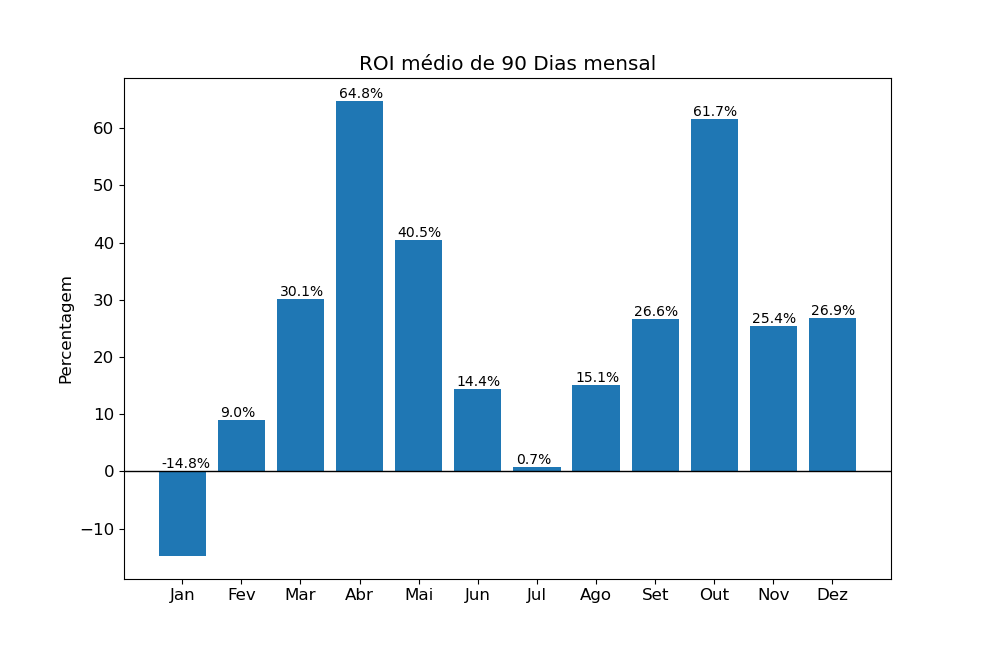

In [22]:
%matplotlib notebook
fig, ax = plt.subplots()

ax.bar(roi90mensal["Meses"], roi90mensal["ROI 90 Dias Médio"], label = "ROI 90 Dias Médio")

plt.ylabel('Percentagem')
plt.axhline(y = 0, color = 'black', linewidth=1) 
plt.ylabel('Percentagem')

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(roi90mensal["ROI 90 Dias Médio"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(i-0.355, v+0.5, str(round(roi90mensal["ROI 90 Dias Médio"][i+1],1))+'%', fontsize=10)

plt.title('ROI médio de 90 Dias mensal')
plt.show()

In [14]:
roi60mensal

,Meses,ROI 60 Dias 2014,ROI 60 Dias 2015,ROI 60 Dias 2016,ROI 60 Dias 2017,ROI 60 Dias 2018,ROI 60 Dias 2019,ROI 60 Dias 2020,ROI 60 Dias Médio
1,Jan,-26.882799,-10.626959,-0.703455,26.454687,-22.946962,3.337070,18.871524,-1.785271
2,Fev,-47.446908,11.522223,12.320202,11.301254,-32.408170,20.815560,-31.009198,-7.843577
3,Mar,-20.551892,-8.337631,3.832432,9.972418,-9.868263,36.275937,2.238295,1.937328
4,Abr,29.617479,-6.928159,27.510954,114.611478,5.814484,102.530694,50.469466,46.232342
5,Mai,40.137814,12.746407,48.393255,76.844214,-32.788330,126.204404,6.672338,39.744300
6,Jun,-8.900813,27.027966,15.686719,17.870494,9.728391,11.576866,17.422119,12.915963
7,Jul,-22.114810,-11.432209,-14.996090,86.645141,10.684827,-12.885224,25.484488,8.769446
8,Ago,-34.774577,-15.908399,0.414447,56.981811,-14.630900,-19.861036,-4.309149,-4.583972
9,Set,-29.261491,37.468761,22.216326,30.956176,-9.901622,-4.532129,15.976683,8.988958
10,Out,-1.161212,59.111501,20.893551,139.355935,-35.414261,-6.654655,68.695148,34.975144


In [15]:
roi60mensal.to_csv("bitcoin_roi_60_dias_mensal_2014-2020.csv", index=False)

# Representação gráfica de ROI de 60 dias mensal médio¶
## Tamanho de amostras para o estudo:
Foi usado dados diários a partir do dia 1 de Janeiro de 2014 até 1 de Janeiro de 2021

<IPython.core.display.Javascript object>


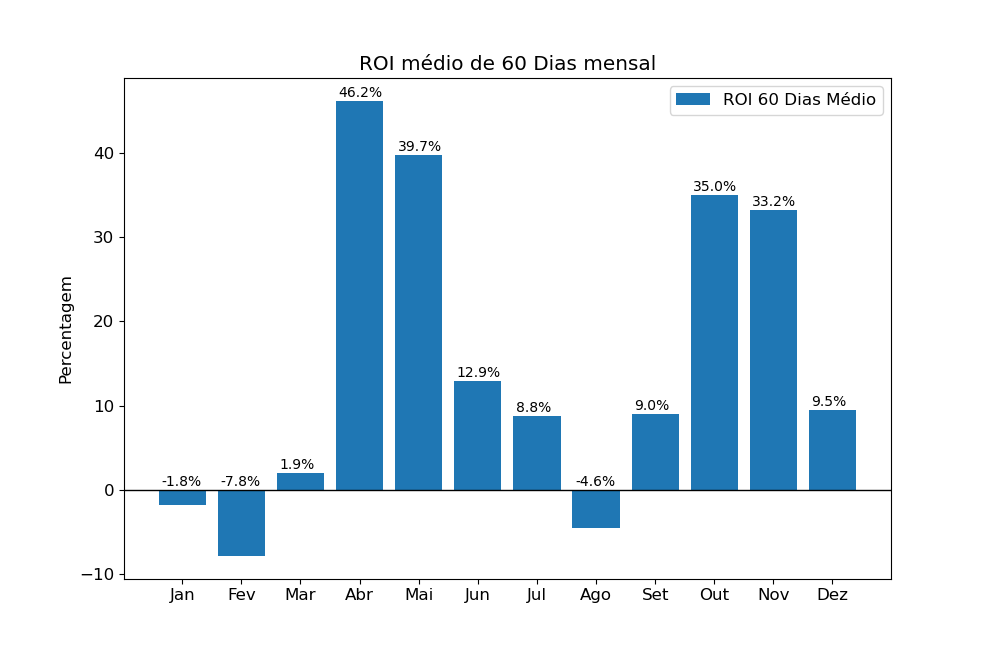

In [23]:
%matplotlib notebook
fig, ax = plt.subplots()

ax.bar(roi60mensal["Meses"], roi60mensal["ROI 60 Dias Médio"], label = "ROI 60 Dias Médio")


plt.ylabel('Percentagem')
plt.axhline(y = 0, color = 'black', linewidth=1) 
plt.legend()

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(roi60mensal["ROI 60 Dias Médio"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(i-0.355, v+0.5, str(round(roi60mensal["ROI 60 Dias Médio"][i+1],1))+'%', fontsize=10)

plt.title('ROI médio de 60 Dias mensal')
plt.show()

In [17]:
roi30mensal

,Meses,ROI 30 Dias 2014,ROI 30 Dias 2015,ROI 30 Dias 2016,ROI 30 Dias 2017,ROI 30 Dias 2018,ROI 30 Dias 2019,ROI 30 Dias 2020,ROI 30 Dias Médio
1,Jan,6.537369,-27.937750,-16.130443,-2.984189,-29.118998,-6.354690,32.169586,-6.259873
2,Fev,-29.636525,24.021997,14.403799,30.709107,9.724467,11.296867,-7.952871,7.509549
3,Mar,-18.337648,-5.602592,-3.710263,-12.155211,-33.338244,7.554467,-25.135632,-12.960732
4,Abr,-4.935073,-5.687437,8.599318,29.780337,31.868480,28.981989,34.086434,17.527721
5,Mai,36.346267,-1.315544,17.414139,65.365172,-19.757562,57.022461,12.218262,23.899028
6,Jun,0.589429,15.309124,25.695516,0.155345,-14.660094,26.965324,-3.351020,7.243375
7,Jul,-9.434631,10.162979,-7.962732,17.687672,28.578054,-12.120205,21.493387,6.914932
8,Ago,-19.169193,-18.034573,-5.611042,71.780275,-9.228240,-4.710414,3.315092,2.620272
9,Set,-19.949771,4.654233,7.430131,-10.602382,-5.714491,-13.906091,-7.722907,-6.544468
10,Out,-11.632346,31.355185,13.763546,46.487322,-4.440906,10.888066,25.683069,16.014848


In [18]:
roi30mensal.to_csv("bitcoin_roi_30_dias_mensal_2014-2020.csv", index=False)

# Representação gráfica de ROI de 30 dias mensal médio¶
## Tamanho de amostras para o estudo:
Foi usado dados diários a partir do dia 1 de Janeiro de 2014 até 1 de Janeiro de 2021

<IPython.core.display.Javascript object>


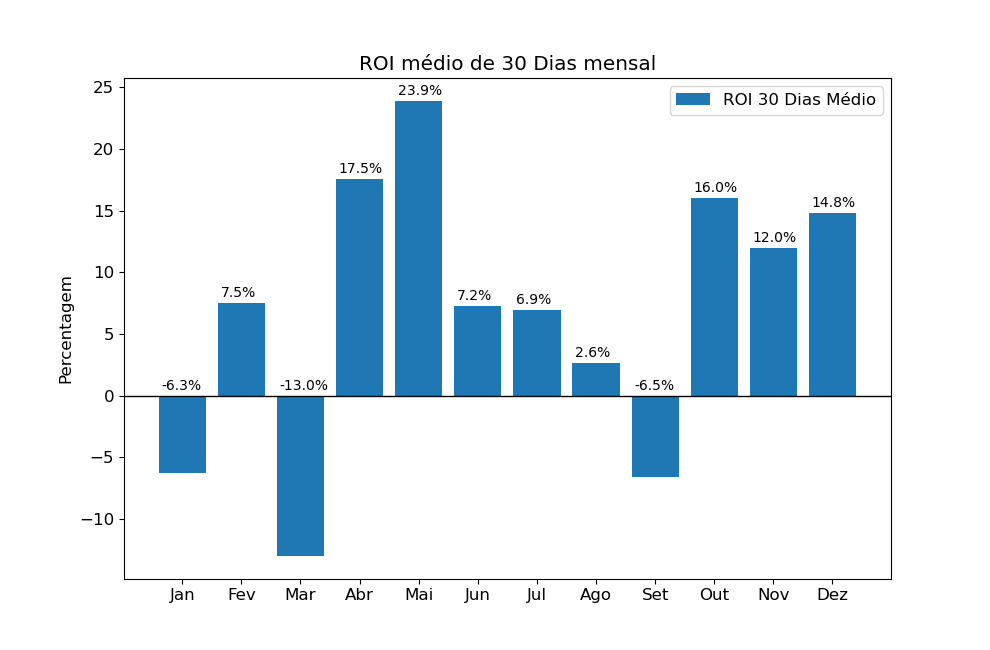

In [24]:
%matplotlib notebook
fig, ax = plt.subplots()

ax.bar(roi30mensal["Meses"], roi30mensal["ROI 30 Dias Médio"], label = "ROI 30 Dias Médio")


plt.ylabel('Percentagem')
plt.axhline(y = 0, color = 'black', linewidth=1)  
plt.legend()

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(roi30mensal["ROI 30 Dias Médio"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(i-0.355, v+0.5, str(round(roi30mensal["ROI 30 Dias Médio"][i+1],1))+'%', fontsize=10)

plt.title('ROI médio de 30 Dias mensal')
plt.show()